In [1]:
import numpy as np
import pandas as pd
import math
import torch
import config as cfg
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools.regressors import CoxPH, RSF, DeepSurv, DSM, BNNmcd
from tools.feature_selectors import PHSelector
from utility.builder import Builder
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines.statistics import proportional_hazard_test
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time
import config as cfg
from sklearn.preprocessing import StandardScaler
from tools.formatter import Formatter
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import make_event_times
from utility.data import get_window_size, get_lag
from utility.survival import coverage

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

# Paths
DATASET_PATH_XJTU = "../data/XJTU-SY/csv/"
RAW_DATA_PATH_XJTU = ["../data/XJTU-SY/35Hz12kN/", "../data/XJTU-SY/37.5Hz11kN/", "../data/XJTU-SY/40Hz10kN/"]
RESULTS_PATH = "../results"
PLOTS_PATH = "../plots"
RESULT_PATH_XJTU= "../data/XJTU-SY/results/"

NEW_DATASET = False
DATASET = "xjtu"

PERCENTAGE = 0.25
N_POST_SAMPLES = 1000 # number of samples to draw from MCD posterior
N_CONDITION = len(RAW_DATA_PATH_XJTU)
PLOTS_PATH = PLOTS_PATH
N_BEARING = cfg.N_REAL_BEARING_XJTU
DATASET_PATH = DATASET_PATH_XJTU
N_BOOT = 0

#For the first time running, a NEW_DATASET is needed
if NEW_DATASET== True:
    Builder(DATASET, N_BOOT).build_new_dataset(bootstrap=N_BOOT)
    
data_util = DataETL(DATASET, N_BOOT)

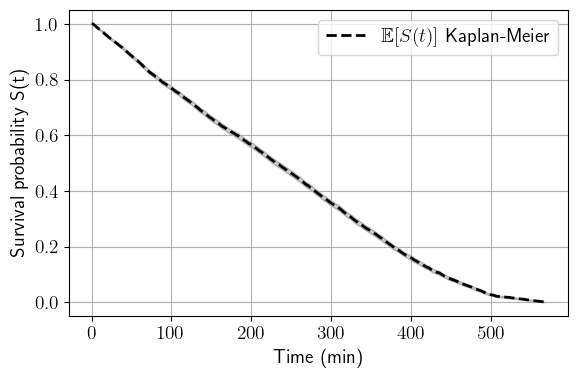

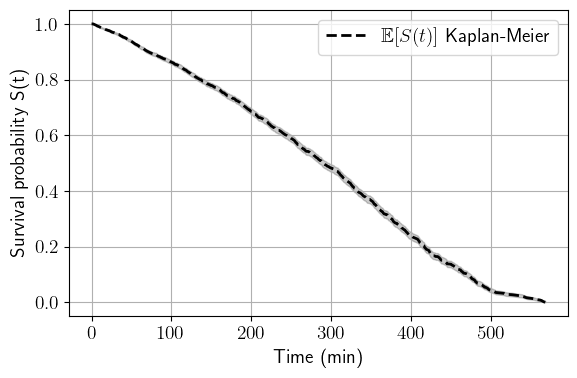

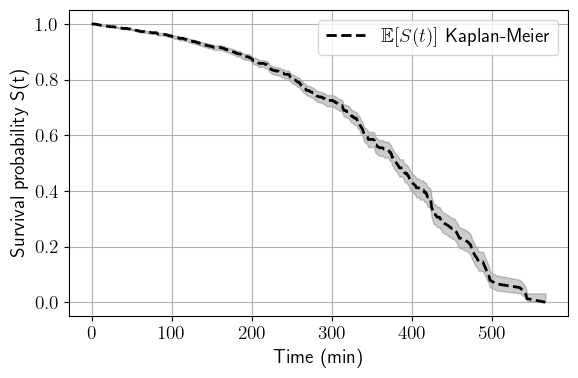

In [18]:
# Plot KM
CONDITION_SELECTOR = 2
timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(CONDITION_SELECTOR, N_BOOT)
data_util = DataETL(DATASET, N_BOOT)
data = pd.DataFrame()
window_size = get_window_size(CONDITION_SELECTOR)
lag = get_lag(CONDITION_SELECTOR)
bearing_indicies = list(range(1, (N_BEARING*2)+1))
for idx in bearing_indicies:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    data = pd.concat([data, transformed_data], axis=0)
data = data.reset_index(drop=True)

for cens in [0.25, 0.5, 0.75]:
    data = Formatter.add_random_censoring(data, percentage=cens)
    y = Surv.from_dataframe("Event", "Survival_time", data)
    np.random.shuffle(y)
    event_times = make_event_times(np.array(y['Survival_time']), np.array(y['Event'])).astype(int)
    event_times = np.unique(event_times)
    fig = plt.figure(figsize=(6, 4))
    km_mean, km_high, km_low = calculate_kaplan_vectorized(y['Survival_time'].reshape(1,-1),
                                                           y['Event'].reshape(1,-1),
                                                           event_times)
    plt.plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=1,
             label=r"$\mathbb{E}[S(t)]$ Kaplan-Meier", color="black")
    plt.fill_between(km_mean.columns, km_low.iloc[0], km_high.iloc[0], alpha=0.2, color="black")
    plt.xlabel("Time (min)")
    plt.ylabel("Survival probability S(t)")
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.savefig(f'{PLOTS_PATH}/kaplan_meier_cond_{CONDITION_SELECTOR+1}_cens_{int(cens*100)}.pdf', format='pdf', bbox_inches="tight")

In [4]:
# Print event time and bearing lifetime
real_lifetimes = cfg.DATASHEET_LIFETIMES
bearing_numbers = list(range(1, (N_BEARING*2)+1))
for cond in [0, 1, 2]:
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    data_util = DataETL(DATASET, N_BOOT)
    data = pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    for idx in bearing_numbers:
        event_time = data_util.event_analyzer(idx, info_pack)
        if cond == 0: cond_name = "C1"
        elif cond == 1: cond_name = "C2"
        else: cond_name = "C3"
        bearing_idx = (idx+1) // 2
        lifetime = real_lifetimes[f'{DATASET}_{cond_name.lower()}_b{bearing_idx}']
        
        bearing = f'& Bearing {cond_name[1:2]}\_{bearing_idx}\_{"Y" if idx % 2 == 0 else "X"}'
        error = event_time-lifetime
        pct_error = (lifetime-event_time)/(lifetime)*100
        if cond == 0:
            l10 = 580
        elif cond == 1:
            l10 = 703
        else:
            l10 = 878
        print(f"{bearing} & {event_time} & {lifetime} & {int(error)} & {int(round(pct_error, 0))} & {l10} \\\\")
    print()

& Bearing 1\_1\_X & 80.0 & 123 & -43 & 35 & 580 \\
& Bearing 1\_1\_Y & 70.0 & 123 & -53 & 43 & 580 \\
& Bearing 1\_2\_X & 120.0 & 161 & -41 & 25 & 580 \\
& Bearing 1\_2\_Y & 110.0 & 161 & -51 & 32 & 580 \\
& Bearing 1\_3\_X & 100.0 & 158 & -58 & 37 & 580 \\
& Bearing 1\_3\_Y & 110.0 & 158 & -48 & 30 & 580 \\
& Bearing 1\_4\_X & 70.0 & 122 & -52 & 43 & 580 \\
& Bearing 1\_4\_Y & 60.0 & 122 & -62 & 51 & 580 \\
& Bearing 1\_5\_X & 30.0 & 52 & -22 & 42 & 580 \\
& Bearing 1\_5\_Y & 30.0 & 52 & -22 & 42 & 580 \\

& Bearing 2\_1\_X & 260.0 & 491 & -231 & 47 & 703 \\
& Bearing 2\_1\_Y & 290.0 & 491 & -201 & 41 & 703 \\
& Bearing 2\_2\_X & 110.0 & 161 & -51 & 32 & 703 \\
& Bearing 2\_2\_Y & 140.0 & 161 & -21 & 13 & 703 \\
& Bearing 2\_3\_X & 270.0 & 533 & -263 & 49 & 703 \\
& Bearing 2\_3\_Y & 300.0 & 533 & -233 & 44 & 703 \\
& Bearing 2\_4\_X & 20.0 & 42 & -22 & 52 & 703 \\
& Bearing 2\_4\_Y & 20.0 & 42 & -22 & 52 & 703 \\
& Bearing 2\_5\_X & 120.0 & 339 & -219 & 65 & 703 \\
& Bearing 2\_5\_Y 

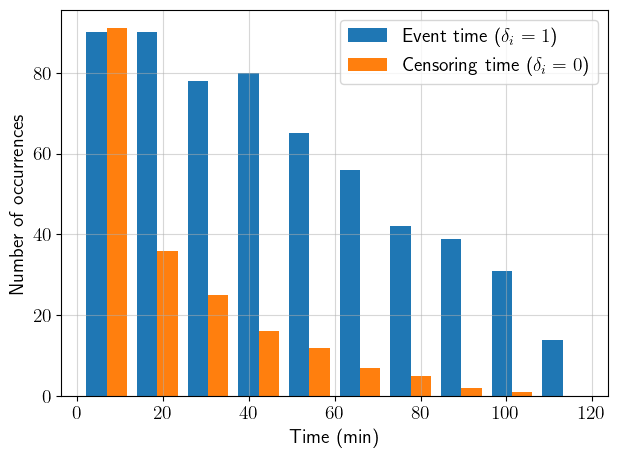

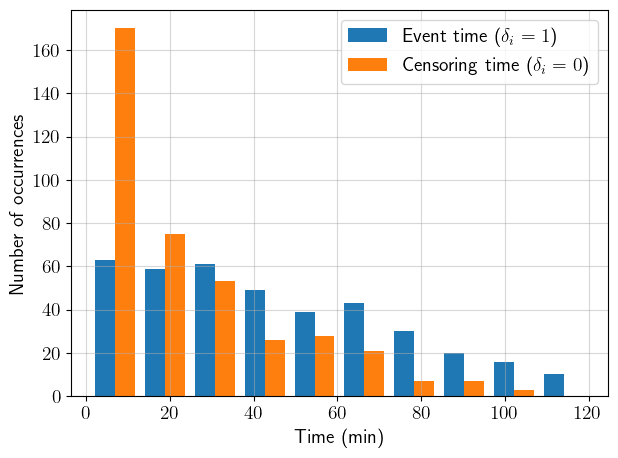

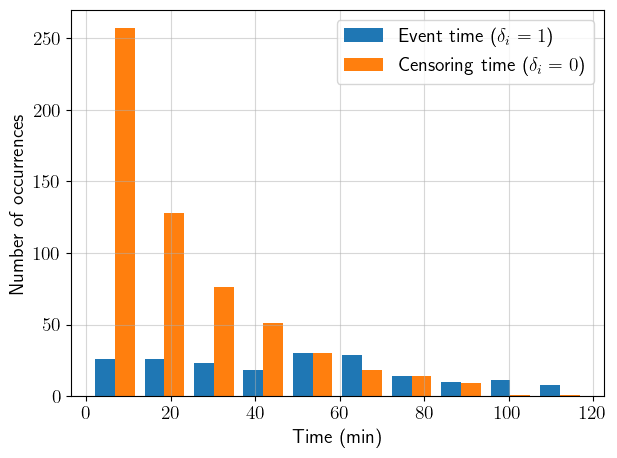

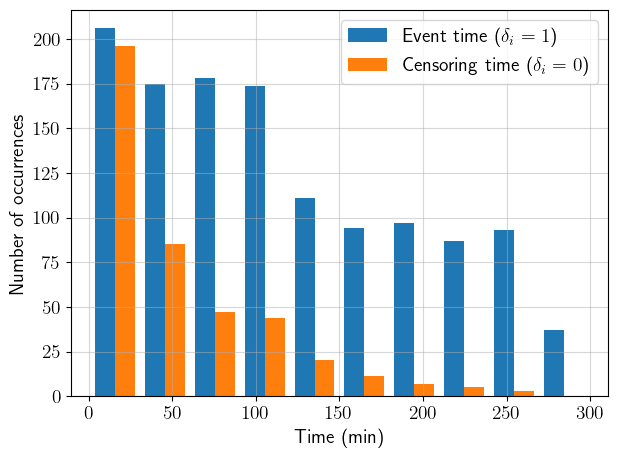

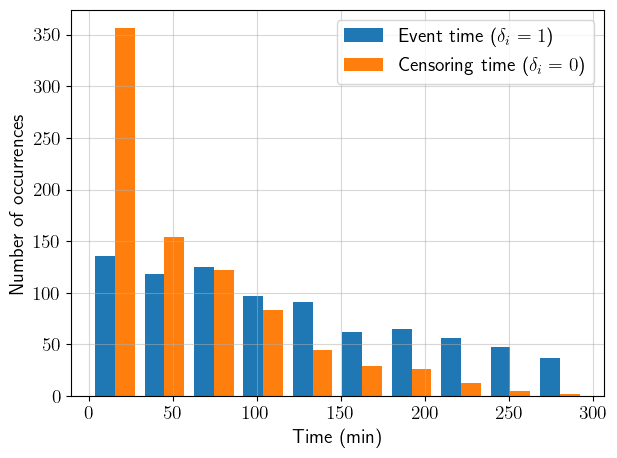

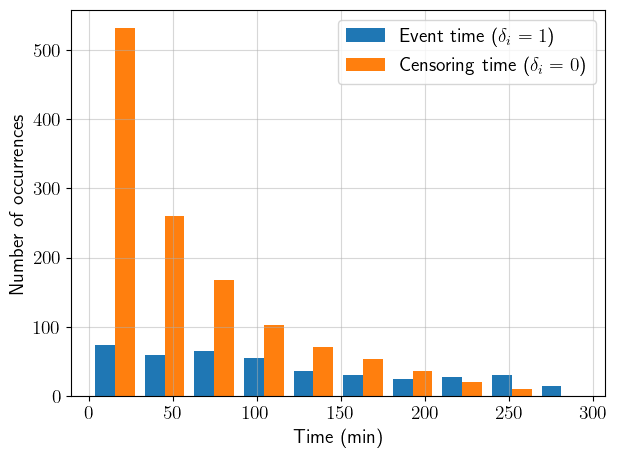

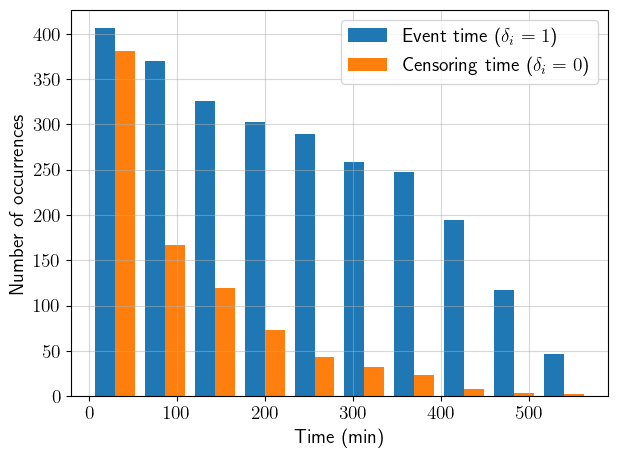

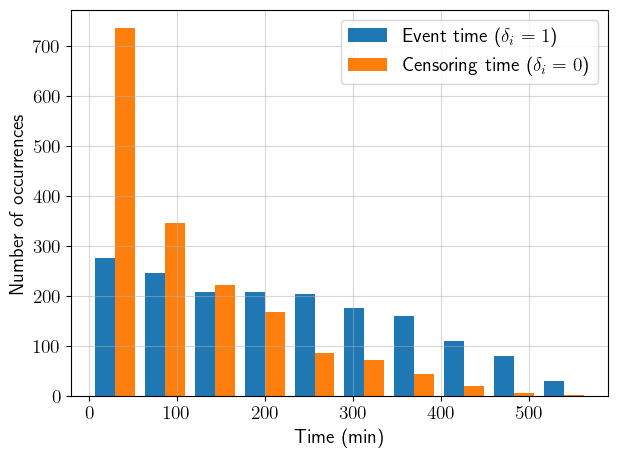

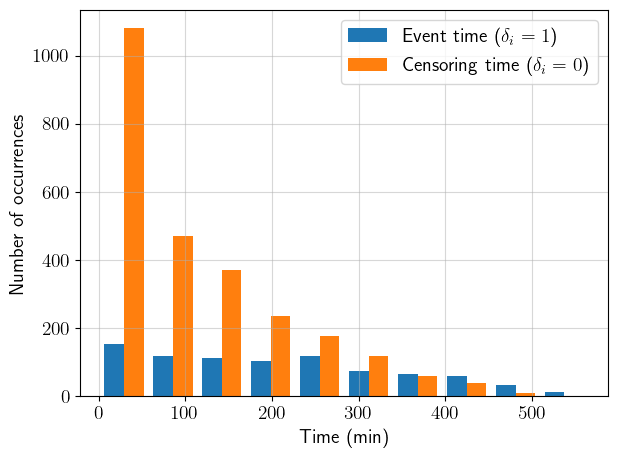

In [24]:
for cond in [0, 1, 2]:
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    data_util = DataETL(DATASET, N_BOOT)
    data = pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    bearing_indicies = list(range(1, (N_BEARING*2)+1))
    for idx in bearing_indicies:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        data = pd.concat([data, transformed_data], axis=0)
    data = data.reset_index(drop=True)
    
    for cens in cfg.CENSORING_LEVELS:
        censored_data = Formatter.add_random_censoring(data, percentage=cens)
        fig, ax = plt.subplots()
        val, bins, patches = plt.hist((censored_data["Survival_time"][censored_data["Event"]],
                                       censored_data["Survival_time"][~censored_data["Event"]]),
                                      bins=10,
                                      stacked=False)
        plt.legend(patches, ["Event time (" + r"$\delta_{i} = 1$" + ")", "Censoring time (" + r"$\delta_{i} = 0$" + ")"])
        plt.xlabel("Time (min)")
        plt.ylabel("Number of occurrences")
        plt.tight_layout()
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        plt.savefig(f'{PLOTS_PATH}/event_times_cond_{cond+1}_cens_{int(cens*100)}.pdf',
                    format='pdf', bbox_inches="tight")

 27%|██▋       | 27/100 [00:05<00:14,  5.05it/s]


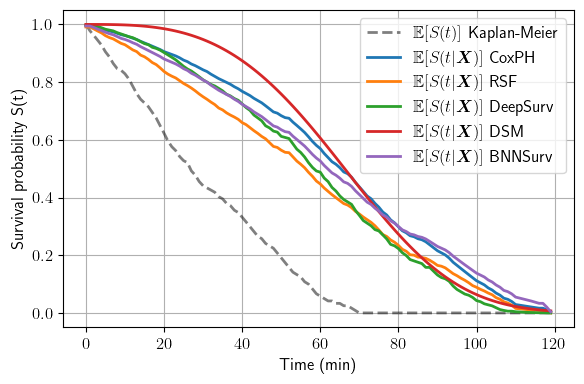

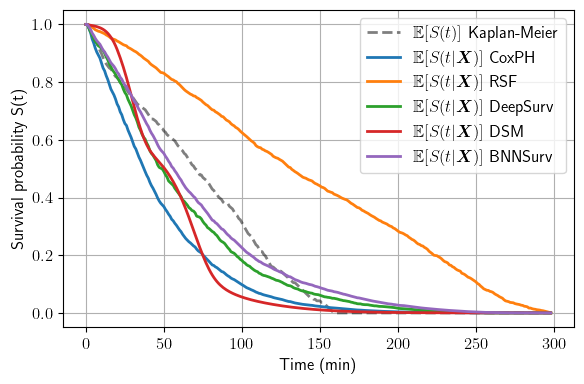

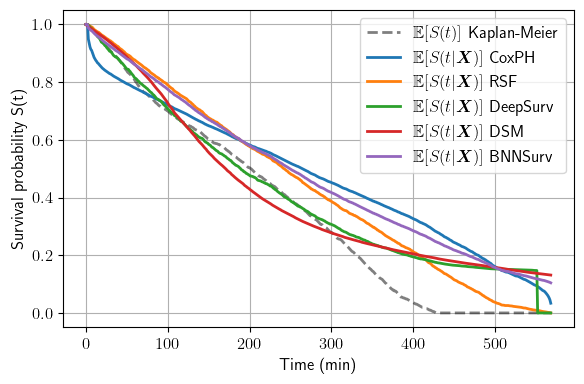

In [7]:
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 12.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})


for cond in [0, 1, 2]:
    # Build timeseries data
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)

    train_data, test_data = pd.DataFrame(), pd.DataFrame()
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    train_idx = list(range(1, 7))
    test_idx = list(range(7, 11))
    
    for idx in train_idx:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        train_data = pd.concat([train_data, transformed_data], axis=0)
    for idx in test_idx:
        event_time = data_util.event_analyzer(idx, info_pack)
        transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
        test_data = pd.concat([test_data, transformed_data], axis=0)
    
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
    test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
    train_data = train_data.sample(frac=1, random_state=0)
    test_data = test_data.sample(frac=1, random_state=0)

    x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
    y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
    x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
    y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

    #Set event times for models
    event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
    event_times = np.unique(event_times)

    #Set the feature selector and train/test split
    best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
    X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

    # Scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Format the data for NN models
    t_train = y_train['Survival_time']
    e_train = y_train['Event']
    t_test = y_test['Survival_time']
    e_test = y_test['Event']

    #Make models
    cph_model = CoxPH().make_model(CoxPH().get_best_hyperparams())
    rsf_model = RSF().make_model(RSF().get_best_hyperparams())
    deep_surv_model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    dsm_model = DSM().make_model(DSM().get_best_hyperparams())
    bnn_model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

    #Train model
    deepsurv_params = DeepSurv().get_best_hyperparams()
    dsm_params = DSM().get_best_hyperparams()
    cph_model.fit(X_train_scaled, y_train)
    rsf_model.fit(X_train_scaled, y_train)
    deep_surv_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                    iters=deepsurv_params['iters'],
                    learning_rate=deepsurv_params['learning_rate'],
                    batch_size=deepsurv_params['batch_size'])
    dsm_model.fit(X_train_scaled, t_train, e_train, vsize=0.3,
                iters=dsm_params['iters'],
                learning_rate=dsm_params['learning_rate'],
                batch_size=dsm_params['batch_size'])
    bnn_model.fit(X_train_scaled, t_train, e_train)

    #Predict
    survival = Survival()
    cph_surv_func = survival.predict_survival_function(cph_model, X_test_scaled, event_times)
    rsf_surv_func = survival.predict_survival_function(rsf_model, X_test_scaled, event_times)
    deep_surv_surv_func = survival.predict_survival_function(deep_surv_model, X_test_scaled, event_times)
    dsm_surv_func = survival.predict_survival_function(dsm_model, X_test_scaled, event_times)
    bnn_surv_func = survival.predict_survival_function(bnn_model, X_test_scaled, event_times,
                                                       n_post_samples=N_POST_SAMPLES)
    km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                           y_test['Event'].reshape(1,-1),
                                                           event_times)
    fig = plt.figure(figsize=(6, 4))
    plt.plot(km_mean.columns, km_mean.iloc[0], 'k--', linewidth=2, alpha=0.5, label=r"$\mathbb{E}[S(t)]$ Kaplan-Meier", color="black")
    plt.plot(event_times, np.mean(cph_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ CoxPH", color="C0", linewidth=2)
    plt.plot(event_times, np.mean(rsf_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ RSF", color="C1", linewidth=2)
    plt.plot(event_times, np.mean(deep_surv_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DeepSurv", color="C2", linewidth=2)
    plt.plot(event_times, np.mean(dsm_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ DSM", color="C3", linewidth=2)
    plt.plot(event_times, np.mean(bnn_surv_func, axis=0), label=r"$\mathbb{E}[S(t|\bm{X})]$ BNNSurv", color="C4", linewidth=2)
    plt.xlabel("Time (min)")
    plt.ylabel("Survival probability S(t)")
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.savefig(f'{PLOTS_PATH}/mean_survival_cond_{cond+1}.pdf', format='pdf', bbox_inches="tight")

In [33]:
print(list(range(1, 7)))
print(list(range(7, 11)))

[1, 2, 3, 4, 5, 6]
[7, 8, 9, 10]


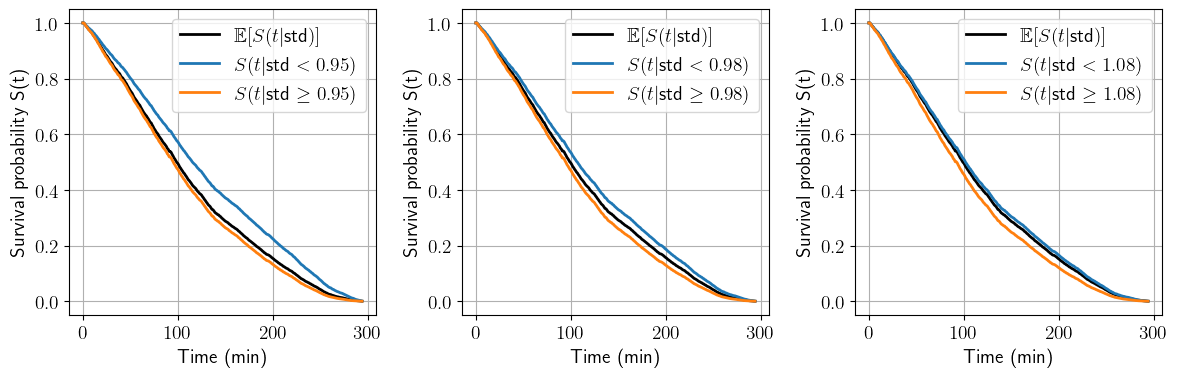

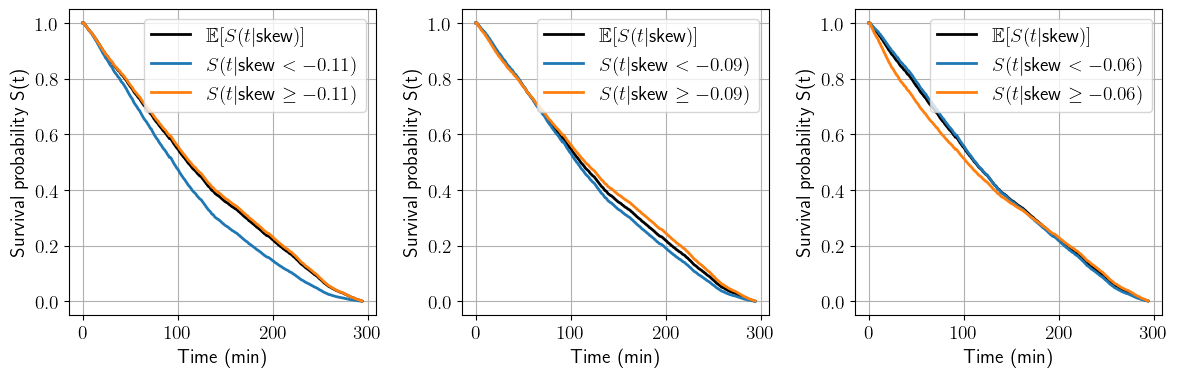

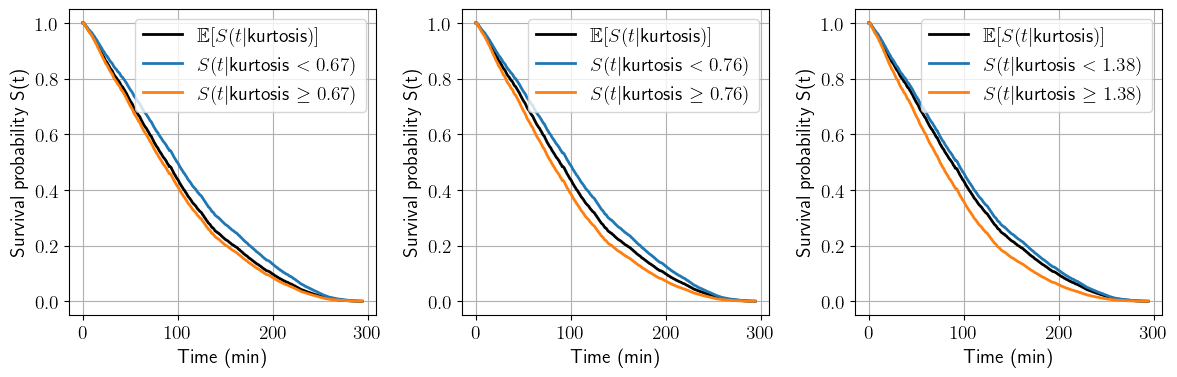

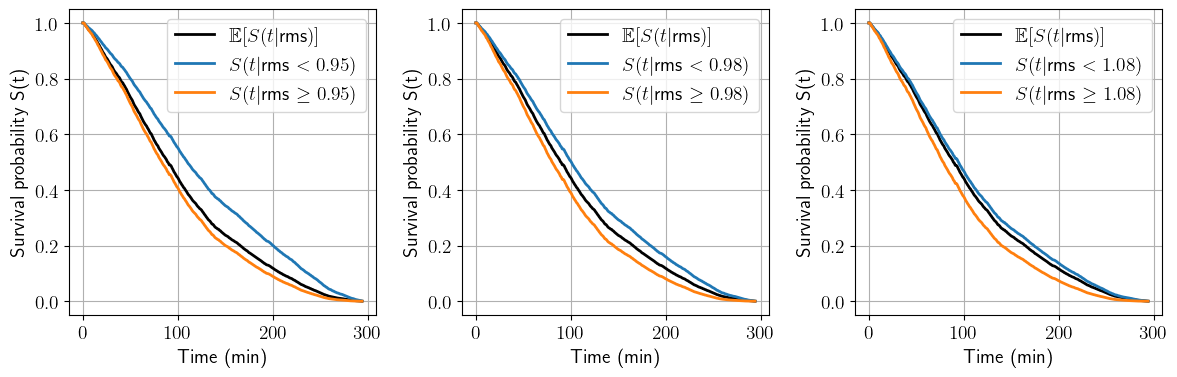

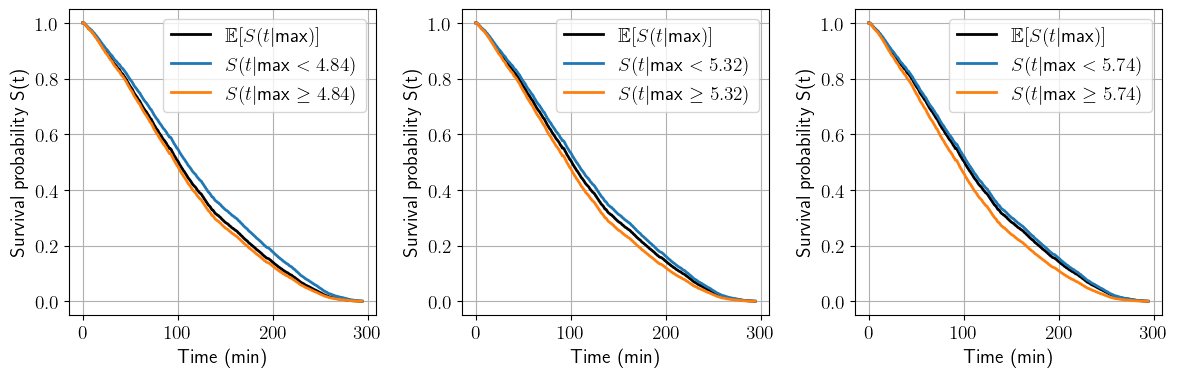

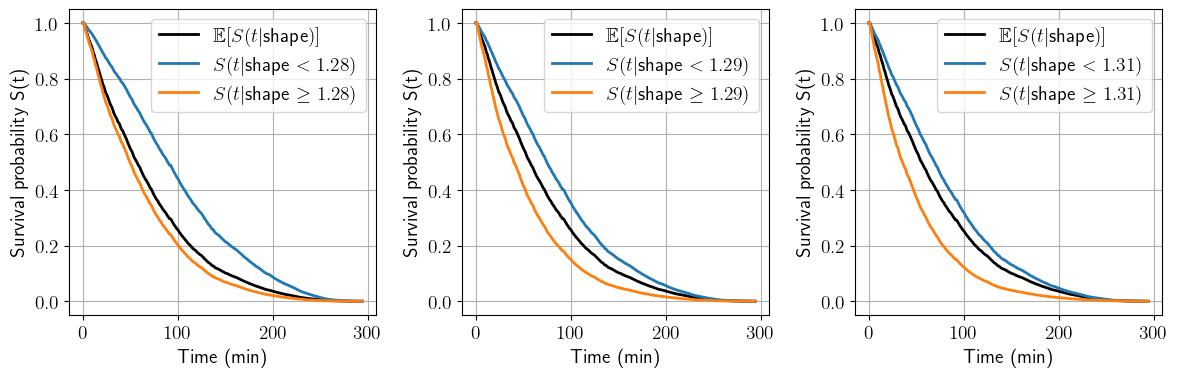

In [9]:
# Build timeseries data
cond = 1
timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
window_size = get_window_size(cond)
lag = get_lag(cond)
train_idx = list(range(1, 7)) # bearings 1-6 for train
test_idx = list(range(7, 11)) # bearings 7-10 for test

train_data, test_data = pd.DataFrame(), pd.DataFrame()
for idx in train_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    train_data = pd.concat([train_data, transformed_data], axis=0)
for idx in test_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    test_data = pd.concat([test_data, transformed_data], axis=0)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
train_data = train_data.sample(frac=1, random_state=0)
test_data = test_data.sample(frac=1, random_state=0)

x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

# Split data
features_to_split = best_features
for feature in features_to_split:
    X_train_feature, X_test_feature = pd.DataFrame(X_train[feature]), pd.DataFrame(X_test[feature])

    # Scale train data
    scaler = StandardScaler()
    scaler.fit(X_train_feature)
    X_train_scaled = scaler.transform(X_train_feature)

    #model.fit(X_train, y_train)
    model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())
    #model = DeepSurv().make_model(DeepSurv().get_best_hyperparams())
    model.fit(X_train_scaled, t_train, e_train)
    split_thresholds = []
    for qct in [0.25, 0.5, 0.75]:
        split_thresholds.append(round(X_test_feature[feature].quantile(qct), 2))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, st in enumerate(split_thresholds):
        g1_idx = X_test_feature.loc[X_test_feature[feature] < st].index
        g2_idx = X_test_feature.loc[X_test_feature[feature] >= st].index
        X_test_g1 = X_test_feature.loc[g1_idx]
        X_test_g2 = X_test_feature.loc[g2_idx]
        y_test_g1 = y_test[g1_idx]
        y_test_g2 = y_test[g2_idx]

        # Scale splitted data
        X_test_scaled = scaler.transform(X_test_feature)
        X_test_g1_scaled = scaler.transform(X_test_g1)
        X_test_g2_scaled = scaler.transform(X_test_g2)

        # Predict for mean and two groups
        survival = Survival()
        surv_probs = survival.predict_survival_function(model, X_test_scaled, event_times,
                                                        n_post_samples=N_POST_SAMPLES)
        km_mean, km_high, km_low = calculate_kaplan_vectorized(y_test['Survival_time'].reshape(1,-1),
                                                               y_test['Event'].reshape(1,-1),
                                                               event_times)
        surv_probs_g1 = survival.predict_survival_function(model, X_test_g1_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        km_mean_g1, km_high_g1, km_low_g1 = calculate_kaplan_vectorized(y_test_g1['Survival_time'].reshape(1,-1),
                                                                        y_test_g1['Event'].reshape(1,-1),
                                                                        event_times)
        surv_probs_g2 = survival.predict_survival_function(model, X_test_g2_scaled, event_times,
                                                           n_post_samples=N_POST_SAMPLES)
        
        surv_probs_mean = np.mean(surv_probs, axis=0)
        surv_probs_g1_mean = np.mean(surv_probs_g1, axis=0)
        surv_probs_g2_mean = np.mean(surv_probs_g2, axis=0)
        
        # Plot
        axes[i].plot(surv_probs_mean, linewidth=2, label=r"$\mathbb{E}[S(t|$" + f"{feature}" + r"$)]$", color="black")
        axes[i].plot(surv_probs_g1_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $<{st})$", color="C0")
        axes[i].plot(surv_probs_g2_mean, linewidth=2, label=r"$S(t|$" + f"{feature} $\geq{st})$", color="C1")
        axes[i].set_xlabel("Time (min)")
        axes[i].set_ylabel("Survival probability S(t)")
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
        fig.tight_layout()
        fig.show()
    plt.savefig(f'{PLOTS_PATH}/group_survival_{feature}_cond_{cond+1}.pdf',
                format='pdf', bbox_inches="tight")

In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
bearing_indicies =  list(range(1, (N_BEARING*2)+1)) # number of real bearings x2
for _, (train_idx, test_idx) in enumerate(kf.split(bearing_indicies)):
    print(f'{train_idx} - {test_idx}')

[2 3 4 5 6 7 8 9] - [0 1]
[0 1 4 5 6 7 8 9] - [2 3]
[0 1 2 3 6 7 8 9] - [4 5]
[0 1 2 3 4 5 8 9] - [6 7]
[0 1 2 3 4 5 6 7] - [8 9]


In [41]:
# Build timeseries data
cond = 1
timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
window_size = get_window_size(cond)
lag = get_lag(cond)
train_idx = [3, 4, 5, 6, 7, 8, 9, 10]
test_idx = [1, 2]

train_data, test_data = pd.DataFrame(), pd.DataFrame()
for idx in train_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    train_data = pd.concat([train_data, transformed_data], axis=0)
for idx in test_idx:
    event_time = data_util.event_analyzer(idx, info_pack)
    transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
    test_data = pd.concat([test_data, transformed_data], axis=0)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
train_data = train_data.sample(frac=1, random_state=0)
test_data = test_data.sample(frac=1, random_state=0)

x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
x_test = test_data.drop(['Event', 'Survival_time'], axis=1)
y_test = Surv.from_dataframe("Event", "Survival_time", test_data)

#Set event times for models
event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
event_times = np.unique(event_times)

#Set the feature selector and train/test split
best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Format the data for NN models
t_train = y_train['Survival_time']
e_train = y_train['Event']
t_test = y_test['Survival_time']
e_test = y_test['Event']

#Set up the models on test
model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

# Train the model
model.fit(X_train_scaled, t_train, e_train)

# Predict
surv_probs = model.predict_survival(X_test_scaled, event_times, N_POST_SAMPLES)

In [42]:
# Computer coverage
credible_region_sizes = np.arange(0.1, 1, 0.1)
surv_times = torch.from_numpy(surv_probs)
coverage_stats = {}
for percentage in credible_region_sizes:
    drop_num = math.floor(0.5 * N_POST_SAMPLES * (1 - percentage))
    lower_outputs = torch.kthvalue(surv_times, k=1 + drop_num, dim=0)[0]
    upper_outputs = torch.kthvalue(surv_times, k=N_POST_SAMPLES - drop_num, dim=0)[0]
    coverage_stats[percentage] = coverage(event_times, upper_outputs, lower_outputs,
                                          t_test, e_test)
print("C-cal:", coverage_stats)

C-cal: {0.1: 0.20292887029288703, 0.2: 0.25313807531380755, 0.30000000000000004: 0.3106694560669456, 0.4: 0.35669456066945604, 0.5: 0.40585774058577406, 0.6: 0.4592050209205021, 0.7000000000000001: 0.5073221757322176, 0.8: 0.5596234309623431, 0.9: 0.6401673640167364}


In [96]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(10, 30), 9)
print(randomlist)

[25, 27, 18, 19, 28, 24, 16, 13, 10]


In [14]:
res = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res2 = [0.15, 0.25, 0.35, 0.45, 0.55, 0.55, 0.5, 0.5, 0.5]

In [15]:
from scipy.stats._stats_py import chisquare
 
# defining the table
data = [res, res2]
_, pvalue = chisquare(data)

# interpret p-value
alpha = 0.05
p = pvalue[0]
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.920344325445942
Independent (H0 holds true)


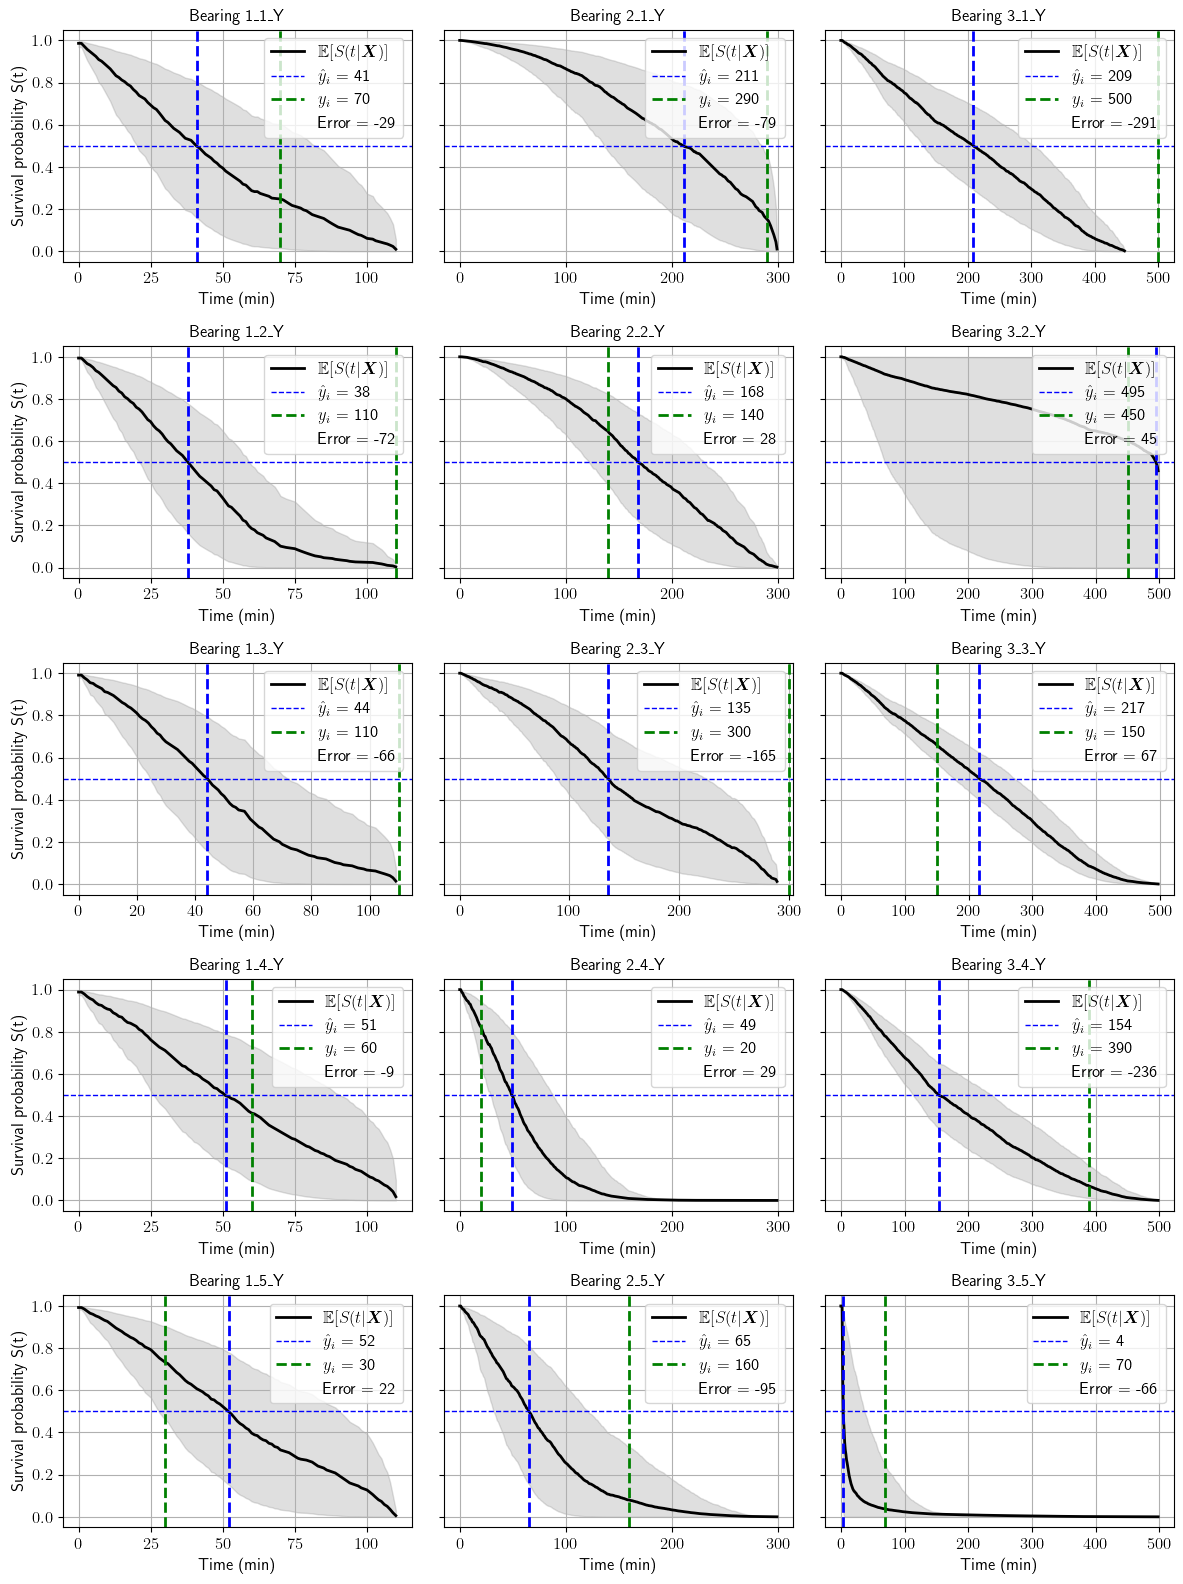

In [67]:
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 12.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from matplotlib.patches import Rectangle

data_util = DataETL(DATASET, N_BOOT)
fig, axes = plt.subplots(5, 3, figsize=(12, 16), sharey=True)

x_bearings = [idx for idx in list(range(1, 11)) if idx % 2 != 0]
y_bearings = [idx for idx in list(range(1, 11)) if idx % 2 == 0]

for cond in [0, 1, 2]:
    # Build timeseries data
    timeseries_data, boot, info_pack = FileReader(DATASET, DATASET_PATH).read_data(cond, N_BOOT)
    window_size = get_window_size(cond)
    lag = get_lag(cond)
    
    # Individual bearing prediction
    bearings = y_bearings
    plot_indicies = [0, 1, 2, 3, 4]
    for test_idx, plot_idx in zip(bearings, plot_indicies):
        train_idx = [x for x in bearings if x != test_idx]
        
        train_data = pd.DataFrame()
        for idx in train_idx:
            event_time = data_util.event_analyzer(idx, info_pack)
            transformed_data = data_util.make_moving_average(timeseries_data, event_time, idx, window_size, lag)
            train_data = pd.concat([train_data, transformed_data], axis=0)
            
        test_event_time = data_util.event_analyzer(test_idx, info_pack)
        test_data = data_util.make_moving_average(timeseries_data, test_event_time, test_idx, window_size, lag)
    
        train_data = train_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        
        train_data = Formatter.add_random_censoring(train_data, percentage=0.25)
        test_data = Formatter.add_random_censoring(test_data, percentage=0.25)
        train_data = train_data.sample(frac=1, random_state=0)
        test_data = test_data.sample(frac=1, random_state=0)
        
        # Select only first observation
        test_sample = test_data[test_data['Survival_time'] == test_data['Survival_time'].max()] \
                     .drop_duplicates(subset="Survival_time")

        x_train = train_data.drop(['Event', 'Survival_time'], axis=1)
        y_train = Surv.from_dataframe("Event", "Survival_time", train_data)
        x_test = test_sample.drop(['Event', 'Survival_time'], axis=1)
        y_test = Surv.from_dataframe("Event", "Survival_time", test_sample)

        #Set event times for models
        event_times = make_event_times(np.array(y_train['Survival_time']), np.array(y_train['Event'])).astype(int)
        event_times = np.unique(event_times)

        #Set the feature selector and train/test split
        best_features = PHSelector(x_train, y_train, estimator=[DATASET, cond]).get_features()
        X_train, X_test = x_train.loc[:,best_features], x_test.loc[:,best_features]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Format the data
        t_train = y_train['Survival_time']
        e_train = y_train['Event']
        t_test = y_test['Survival_time']
        e_test = y_test['Event']
        
        # Set event time
        failure_time = data_util.event_analyzer(test_idx, info_pack)
        
        #Set up the models on test
        model = BNNmcd().make_model(BNNmcd().get_best_hyperparams())

        # Train the model
        model.fit(X_train_scaled, t_train, e_train)
        
        # Predict
        surv_probs = model.predict_survival(X_test_scaled, event_times, N_POST_SAMPLES)
        median_outputs = pd.DataFrame(np.mean(surv_probs, axis=0), columns=event_times)
        
        # Calculate TTE
        lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
        median_survival_time = round(np.median(lifelines_eval.predict_time_from_curve(predict_median_survival_time)))
        
        # Plot
        p1 = axes[plot_idx, cond].plot(np.mean(median_outputs, axis=0).T, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{X})]$", color="black")
        drop_num = math.floor(0.5 * N_POST_SAMPLES * (1 - 0.9))
        lower_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=1+drop_num, dim=0)[0]
        upper_outputs = torch.kthvalue(torch.from_numpy(surv_probs), k=N_POST_SAMPLES-drop_num, dim=0)[0]
        axes[plot_idx, cond].fill_between(event_times, upper_outputs[0,:], lower_outputs[0,:], color="gray", alpha=0.25)
        p2 = axes[plot_idx, cond].axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{median_survival_time}')        
        p3 = axes[plot_idx, cond].axvline(x=test_event_time, linestyle= "dashed",
                                          color='green', linewidth=2.0, label=f'$y_i$ = {int(test_event_time)}')
        axes[plot_idx, cond].axvline(x=int(median_survival_time), linestyle= "dashed", color='blue', linewidth=2.0)
        axes[plot_idx, cond].set_title(f'Bearing {cond+1}_{plot_idx+1}_Y')
        axes[plot_idx, cond].set_xlabel("Time (min)")
        text = f'Error = {int(median_survival_time-test_event_time)}'
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        axes[plot_idx, cond].legend([p1[0], p2, p3, extra], [p1[0].get_label(), p2.get_label(), p3.get_label(), text], loc='upper right')
        if cond == 0:
            axes[plot_idx, cond].set_ylabel("Survival probability S(t)")
        axes[plot_idx, cond].grid(True)
plt.tight_layout()
plt.savefig(f'{PLOTS_PATH}/individual_survival_axis_y.pdf', format='pdf', bbox_inches="tight")